In [22]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import h5py
import quimb as qu
from pathlib import Path
from matplotlib.colors import LogNorm

from itertools import product
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import MultiStepLR
from mpl_toolkits.axes_grid1 import make_axes_locatable

from ml.classes import MLLP
from utils import print_comparison, create_basis, experimental_data
from ml.sfw.optimizers import Adam
from ml.core import train
from ml.utils import calculate_error, load_data

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    'text.latex.preamble': r'\usepackage{bbm}'
})

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Training of Lindblad Dynamycs Approximator

In this notebook we train and test the LDA on data coming from TEBD simulations.

# Sample the data
We first create the synthetic experimental data by sampling the TEBD data.

This can be skipped and use directly the data save in ./data/data_tebd_sampled.hdf5

NOTE: the following cell must be executed even though the dat is not created

In [4]:
prms = {'L': 50,         # length of the
        'V': 0.1,        # magnitude of the interaction
        'T': 10,         # time window of the evolution
        'T_test': 20,    # time window to test the model
        'dt': 0.01,      # interval of sampling time
        'num_traj': 30,  # number of trajectories for each combinations of params
        'N' : 25,        # number of samples for each point in time
        'M' : 25         # number of times for trajcetory
       }

In [5]:
### CREATE - training set
exp_data = {'X' : [],
            'y' : [],
            't' : []}

# import the exact dynamics
gname = 'cohVec_L_' + str(prms['L']) + \
    '_V_' + str(int(prms['V']*1e3)).zfill(4) + \
    '_dt_' + str(int(prms['dt']*1e3)).zfill(4)

with h5py.File('./data/data_tebd.hdf5', 'r') as f:
    data_tebd = f[gname+'/X'][()]
    
t = np.arange(0, prms['T'], prms['dt'])
    
for n in range(prms['num_traj']):
    v_0 = data_tebd[1000*n]
    
    # select some random times at which to sample
    indeces = np.random.choice(range(1, len(t)), prms['M'], replace=False)
    for i in indeces:
        # same initial conditions and time
        exp_data['X'].append(v_0)
        exp_data['t'].append(t[i])
        # the data
        exp_data['y'].append( experimental_data(data_tebd[1000*n+i], N=prms['N']))
        
### SAVE
gname = 'cohVec_L_' + str(prms['L']) + \
        '_V_' + str(int(prms['V']*1e3)).zfill(4) + \
        '_N_' + str(int(prms['N'])) + '_M_' + str(int(prms['M']))

with h5py.File('./data/data_tebd_sampled.hdf5', 'a') as f:
    # create the subgroup
    try:
        subg = f.create_group(gname)
    except:
        subg = f[gname]
        del f[gname+'/X']
        del f[gname+'/y']
        del f[gname+'/t']

    subg.create_dataset('X', data=exp_data['X'])
    subg.create_dataset('y', data=exp_data['y'])
    subg.create_dataset('t', data=exp_data['t'])

## Train the model

Here we train the model.

Some specifications:
- for the case of a weakly interacting chain $V=0.1$ we start with a lr = $0.01$, then gamma = $0.1$
- for the case of strongly interacting chain $V=2$ we start with a lr = $0.05$, then gamma = $0.05$

In [6]:
def train_model(data_dir, ML_params, PRMS):
    # load the data
    train_loader, eval_loader = load_data(data_dir, PRMS['L'],
                                          PRMS['V'], PRMS['N'], PRMS['M'], PRMS['num_traj'], 
                                          ML_params['batch_size'],
                                          ML_params['validation_split'])
    # create the model
    model = MLLP(ML_params['mlp_params']).to(ML_params['device'])

    criterion = torch.nn.MSELoss()
    optimizer = Adam(model.parameters(), lr=0.05)
    scheduler = MultiStepLR(optimizer, milestones=[300, 350], gamma=0.05)

    # train the model
    loss = train(model, criterion, optimizer, scheduler, train_loader,
                ML_params['n_epochs'], ML_params['device'],
                alpha_1=[1e-4,0], alpha_2=[])

    # name the model
    name = 'model_' + str(PRMS['L']) + \
            '_V_' + str(int(PRMS['V']*1e3)).zfill(4) + \
            '_N_' + str(int(PRMS['N'])) + '_M_' + str(int(PRMS['M']))
    # save the model
    torch.save(model.state_dict(), ML_params['model_dir'] + name)

    plt.plot([i for i in range(1, ML_params['n_epochs']+1)], loss)
    plt.yscale('log')
    plt.grid()

Data points used in the training 750
= Starting epoch  1 / 400
=== Mean train loss: 0.057235892862
=== lr: 0.05000
= Starting epoch  2 / 400
=== Mean train loss: 0.056917097420
=== lr: 0.05000
= Starting epoch  3 / 400
=== Mean train loss: 0.055593473216
=== lr: 0.05000
= Starting epoch  4 / 400
=== Mean train loss: 0.054118218521
=== lr: 0.05000
= Starting epoch  5 / 400
=== Mean train loss: 0.050354092071
=== lr: 0.05000
= Starting epoch  6 / 400
=== Mean train loss: 0.039063339432
=== lr: 0.05000
= Starting epoch  7 / 400
=== Mean train loss: 0.029354924336
=== lr: 0.05000
= Starting epoch  8 / 400
=== Mean train loss: 0.024893593043
=== lr: 0.05000
= Starting epoch  9 / 400
=== Mean train loss: 0.023697461933
=== lr: 0.05000
= Starting epoch  10 / 400
=== Mean train loss: 0.022560384745
=== lr: 0.05000
= Starting epoch  11 / 400
=== Mean train loss: 0.021858182425
=== lr: 0.05000
= Starting epoch  12 / 400
=== Mean train loss: 0.021312849596
=== lr: 0.05000
= Starting epoch  13 / 4

=== Mean train loss: 0.008656841082
=== lr: 0.05000
= Starting epoch  106 / 400
=== Mean train loss: 0.008669650803
=== lr: 0.05000
= Starting epoch  107 / 400
=== Mean train loss: 0.008670773357
=== lr: 0.05000
= Starting epoch  108 / 400
=== Mean train loss: 0.008701048481
=== lr: 0.05000
= Starting epoch  109 / 400
=== Mean train loss: 0.008684135973
=== lr: 0.05000
= Starting epoch  110 / 400
=== Mean train loss: 0.008680218831
=== lr: 0.05000
= Starting epoch  111 / 400
=== Mean train loss: 0.008658769230
=== lr: 0.05000
= Starting epoch  112 / 400
=== Mean train loss: 0.008683758167
=== lr: 0.05000
= Starting epoch  113 / 400
=== Mean train loss: 0.008645211036
=== lr: 0.05000
= Starting epoch  114 / 400
=== Mean train loss: 0.008648580561
=== lr: 0.05000
= Starting epoch  115 / 400
=== Mean train loss: 0.008669280447
=== lr: 0.05000
= Starting epoch  116 / 400
=== Mean train loss: 0.008666743524
=== lr: 0.05000
= Starting epoch  117 / 400
=== Mean train loss: 0.008678013459
=== 

=== Mean train loss: 0.008695278938
=== lr: 0.05000
= Starting epoch  209 / 400
=== Mean train loss: 0.008677721955
=== lr: 0.05000
= Starting epoch  210 / 400
=== Mean train loss: 0.008689826354
=== lr: 0.05000
= Starting epoch  211 / 400
=== Mean train loss: 0.008654993959
=== lr: 0.05000
= Starting epoch  212 / 400
=== Mean train loss: 0.008710959616
=== lr: 0.05000
= Starting epoch  213 / 400
=== Mean train loss: 0.008711983450
=== lr: 0.05000
= Starting epoch  214 / 400
=== Mean train loss: 0.008705943823
=== lr: 0.05000
= Starting epoch  215 / 400
=== Mean train loss: 0.008800775744
=== lr: 0.05000
= Starting epoch  216 / 400
=== Mean train loss: 0.008737320080
=== lr: 0.05000
= Starting epoch  217 / 400
=== Mean train loss: 0.008719047221
=== lr: 0.05000
= Starting epoch  218 / 400
=== Mean train loss: 0.008692977019
=== lr: 0.05000
= Starting epoch  219 / 400
=== Mean train loss: 0.008758884544
=== lr: 0.05000
= Starting epoch  220 / 400
=== Mean train loss: 0.008740889840
=== 

=== Mean train loss: 0.008607450873
=== lr: 0.00250
= Starting epoch  312 / 400
=== Mean train loss: 0.008609087517
=== lr: 0.00250
= Starting epoch  313 / 400
=== Mean train loss: 0.008609963891
=== lr: 0.00250
= Starting epoch  314 / 400
=== Mean train loss: 0.008614581699
=== lr: 0.00250
= Starting epoch  315 / 400
=== Mean train loss: 0.008606015705
=== lr: 0.00250
= Starting epoch  316 / 400
=== Mean train loss: 0.008610256948
=== lr: 0.00250
= Starting epoch  317 / 400
=== Mean train loss: 0.008605575499
=== lr: 0.00250
= Starting epoch  318 / 400
=== Mean train loss: 0.008608751309
=== lr: 0.00250
= Starting epoch  319 / 400
=== Mean train loss: 0.008606292307
=== lr: 0.00250
= Starting epoch  320 / 400
=== Mean train loss: 0.008598561088
=== lr: 0.00250
= Starting epoch  321 / 400
=== Mean train loss: 0.008599295591
=== lr: 0.00250
= Starting epoch  322 / 400
=== Mean train loss: 0.008602318975
=== lr: 0.00250
= Starting epoch  323 / 400
=== Mean train loss: 0.008610717331
=== 

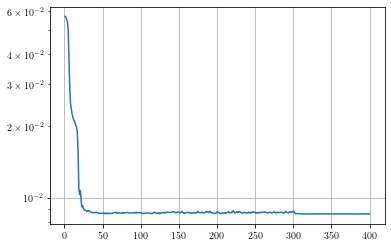

In [7]:
## select the specifications for the training 
ml_params = {'model_dir': './data/trained/',  # folder to store the metadata of the ML model
             'validation_split': 0,
             'batch_size': 256,
             'time_dependent': False,
             'n_epochs': 400,
             'device': 'cpu',
             'mlp_params': {
                 'data_dim': 15,
                 'layers': [],
                 'nonlin': 'id',
                 'output_nonlin': 'id',
                 'dt': 0.01
                 },
             }
prms = {'L': 50,         # length of the
        'V': 0.1,        # magnitude of the interaction
        'T': 10,         # time window of the evolution
        'T_test': 20,    # time window to test the model
        'dt': 0.01,      # interval of sampling time
        'num_traj': 30,  # number of trajectories for each combinations of params
        'N' : 25,        # number of samples for each point in time
        'M' : 25         # number of times for trajcetory
       }

# single train
train_model('./data/data_tebd_sampled.hdf5', ml_params, prms)

# training loop
#for nn in [15,20,25]:
#    for mm in [1,2,3,4,5,10,15,20,25]:
#        prms['N'] = nn
#        prms['M'] = mm
#        print("\n==============================")
#        print(f'N = {nn} M = {mm}')
#        train_model('./data/data_tebd_sampled.hdf5', ml_params, prms)

## Performance of the model

In [8]:
# load the model
name = 'model_' + str(prms['L']) + \
            '_V_' + str(int(prms['V']*1e3)).zfill(4) + \
            '_N_' + str(prms['N']) + '_M_' + str(prms['M'])
model = MLLP(ml_params['mlp_params']).to(ml_params['device'])
model.load_state_dict(torch.load(Path('./data/trained/' + name)))

<All keys matched successfully>

In [9]:
# import test data
gname = 'cohVec_L_' + str(prms['L']) + \
    '_V_' + str(int(prms['V']*1e3)).zfill(4) + \
    '_dt_' + str(int(prms['dt']*1e3)).zfill(4)

with h5py.File('./data/data_tebd_test.hdf5', 'r') as f:
    data_test = f[gname+'/X'][()]

In [11]:
# calculate the average error
errors = np.zeros(10)
for i in range(10):
    ml_dyn = model.generate_trajectory(v_0=np.array(data_test[1000*i]), T=10)    
    errors[i] = calculate_error(results_ml=ml_dyn, results_tebd=data_test[1000*i:1000*(i+1)], T=10, dt=0.01)
print(errors.mean())

0.01030731823137638


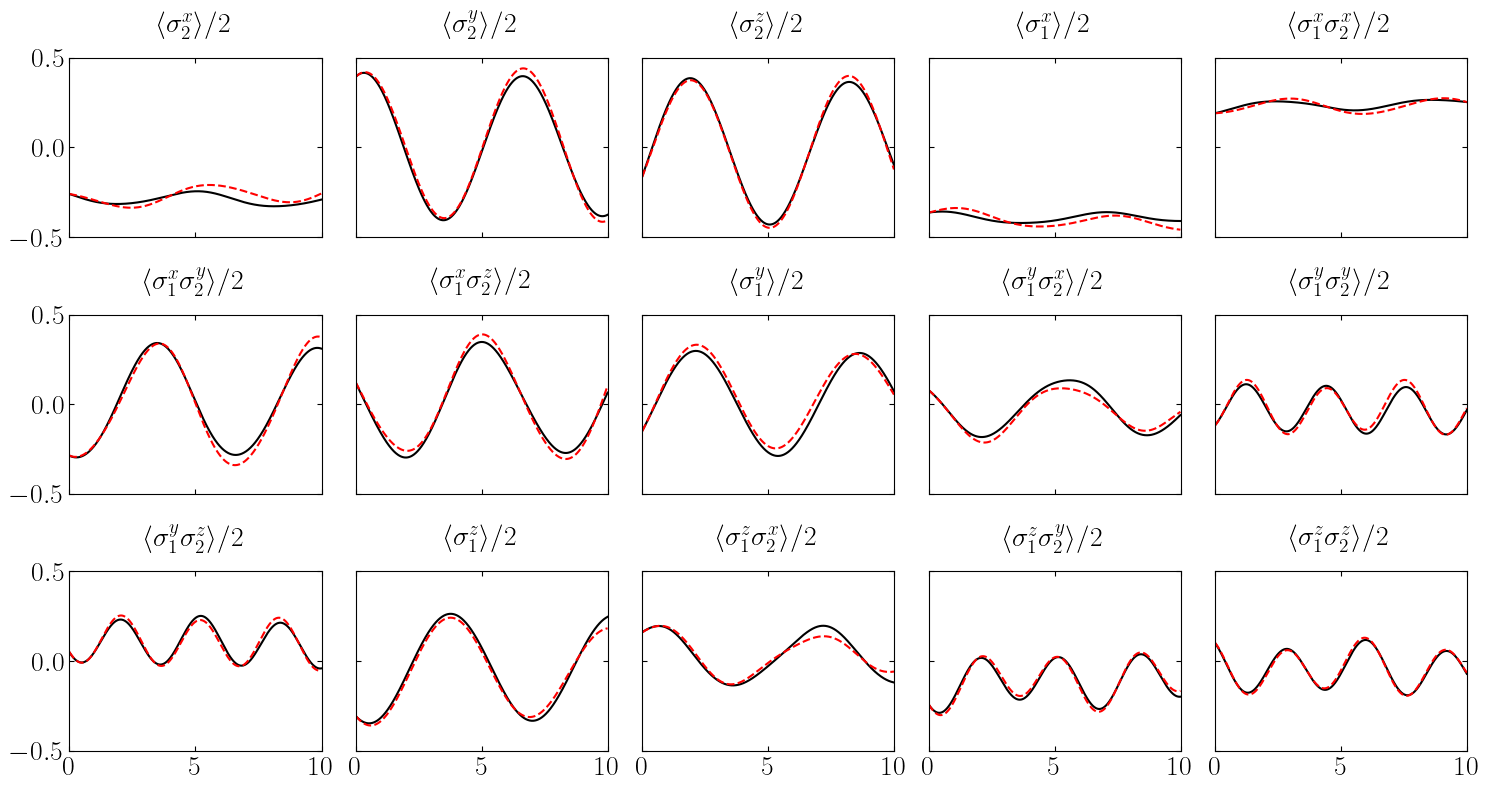

In [12]:
# select the test data to compare with, indx \in [1,10]
indx = 3
# predict dynamics with the model
ml_dyn = model.generate_trajectory(v_0=np.array(data_test[indx*1000]), T=10)    
print_comparison(data_test[indx*1000:(indx*1000 +1000)], ml_dyn, 10, dt=0.01, ylim=0.5)

## Full plot

Here we plot the full grid comparing the model for each combination (N,M)

In [13]:
prms = {'L': 50,         # length of the
        'V': 2,        # magnitude of the interaction
        'T': 10,         # time window of the evolution
        'T_test': 20,    # time window to test the model
        'dt': 0.01,      # interval of sampling time
        'num_traj': 30,  # number of trajectories for each combinations of params
        'N' : 25,        # number of samples for each point in time
        'M' : 25         # number of times for trajcetory
       }

In [14]:
# for each combinations of N and M I calculate the error, averaged over 10 trajectories
N = [1,2,3,4,5,10,15,20,25]
M = [1,2,3,4,5,10,15,20,25]

errors = []

# import test data
gname =  'cohVec_L_' + str(prms['L']) + \
    '_V_' + str(int(prms['V']*1e3)).zfill(4) + \
    '_dt_' + str(int(prms['dt']*1e3)).zfill(4)

with h5py.File('./data/data_tebd_test.hdf5', 'r') as f:
    data_test = f[gname+'/X'][()]

for m in M:
    err = []
    for n in N:
        # name the model
        name = 'model_' + str(prms['L']) + \
            '_V_' + str(int(prms['V']*1e3)).zfill(4) + \
            '_N_' + str(n) + '_M_' + str(m)
        
        # import the model
        model = MLLP(ml_params['mlp_params']).to(ml_params['device'])
        model.load_state_dict(torch.load(Path(ml_params['model_dir'] + name)))
        
        # calculate error
        errs = np.zeros(10)
        for i in range(10):
            ml_dyn = model.generate_trajectory(v_0=np.array(data_test[1000*i]), T=10)    
            errs[i] = calculate_error(results_ml=ml_dyn, results_tebd=data_test[1000*i:1000*(i+1)], T=10, dt=0.01)
    
        err.append(errs.mean())
    errors.append(err)

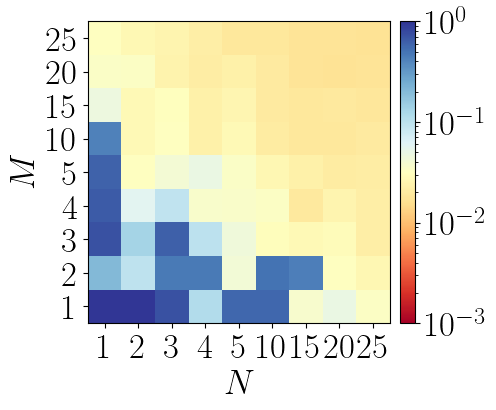

In [15]:
fig, ax = plt.subplots(dpi=100)

im = ax.imshow(errors, origin='lower', cmap='RdYlBu', norm=LogNorm(vmin=0.001, vmax=1))

my_x_ticks = N
my_y_ticks = M
ax.set_xticks([i for i in range(len(my_x_ticks))])
ax.set_xticklabels(['$'+str(i)+'$' for i in my_x_ticks])
ax.set_xlabel(r'$N$', fontsize=25)
ax.set_yticks([i for i in range(len(my_y_ticks))])
ax.set_yticklabels(['$'+str(i)+'$' for i in my_y_ticks])
ax.set_ylabel(r'$M$', fontsize=25)

ax.tick_params(axis='y', labelsize=25)
ax.tick_params(axis='x', labelsize=25)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

cbar = fig.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=25)

plt.show()
#fig.savefig('./plots/V_05.pdf', dpi=150, bbox_inches='tight')

# Explicit expression

Here we briefly show how to extract the expressions for the Hamiltonian and the dissipator.

basis = [IX, IY, IZ, XI, XX, XY, XZ, YI, YX, YY, YZ, ZI, ZX, ZY, ZZ]

In [16]:
basis = ['IX', 'IY', 'IZ', 'XI', 'XX', 'XY', 'XZ', 'YI', 'YX', 'YY', 'YZ', 'ZI', 'ZX', 'ZY', 'ZZ']

# select the model to look at
prms['V'] = 0.1
prms['N'] = 20
prms['M'] = 20

name = 'model_' + str(prms['L']) + \
            '_V_' + str(int(prms['V']*1e3)).zfill(4) + \
            '_N_' + str(prms['N']) + '_M_' + str(prms['M'])
model = MLLP(ml_params['mlp_params']).to(ml_params['device'])
model.load_state_dict(torch.load(Path('./data/trained/' + name)));

### Hamiltonian

In [17]:
H = 0.5*model.MLP.omega.detach().numpy().round(2)

hamiltonian = dict(zip(basis,H))
dict(sorted(hamiltonian.items(), key=lambda item: abs(item[1])))

{'XX': -0.0,
 'YY': 0.0,
 'YZ': 0.0,
 'XY': 0.005,
 'XZ': -0.005,
 'YX': -0.005,
 'ZX': -0.005,
 'ZY': 0.005,
 'ZZ': 0.025,
 'IY': -0.03,
 'YI': -0.03,
 'IZ': 0.055,
 'ZI': 0.055,
 'IX': 0.5,
 'XI': 0.5}

### Dissipator

In [18]:
v_x = model.MLP.v_x
v_y = model.MLP.v_y
c_re = torch.add(torch.einsum('ki,kj->ij', v_x, v_x),\
                torch.einsum('ki,kj->ij', v_y, v_y)  )
c_im = torch.add(torch.einsum('ki,kj->ij', v_x, v_y),\
                -torch.einsum('ki,kj->ij', v_y, v_x) )

koss = (c_re + 1j*c_im).detach().numpy()

In [19]:
e_val, e_vec = np.linalg.eig(koss)

In [20]:
e_val.round(3)

array([ 0.013+0.j,  0.   +0.j,  0.   -0.j,  0.   -0.j,  0.   +0.j,
        0.   -0.j,  0.   +0.j,  0.   -0.j,  0.   +0.j,  0.   +0.j,
        0.   -0.j, -0.   -0.j,  0.   +0.j,  0.   -0.j,  0.   -0.j],
      dtype=complex64)

In [21]:
# indx selects which channel to look at, in this case we look at indx=0, the only one
# with a non-zero decay rate
indx = 0
L = 0.5*e_vec[indx].round(2)

jump = dict(zip(basis, L))
dict(sorted(jump.items(), key=lambda item: abs(item[1])))

{'IX': (-0+0j),
 'IZ': (0.005+0j),
 'YZ': (0.02+0.035j),
 'ZZ': (-0.03+0.06j),
 'ZX': (0.005+0.08j),
 'ZI': (-0.09+0.02j),
 'ZY': (0.03-0.1j),
 'XX': (0.09-0.065j),
 'XI': (-0.05-0.105j),
 'YX': (-0.09-0.08j),
 'YI': (0.095-0.075j),
 'YY': (0.055+0.145j),
 'XY': (-0.16+0.07j),
 'IY': (0.19-0.1j),
 'XZ': (0.245+0j)}